# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

## Постановка задачи

### Исследумемые задачи достижимости
1. Достижимость между всеми парами вершин.
2. Достижимость для каждой из заданного множества стартовых вершин.

### Цель работы
1. Определить какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач.
2. Определить начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные.

### Наборы данных
В эксперименте были использованы следующие графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html)

* Generations - 129 вершин, 273 ребра
* Travel - 131 вершина, 277 ребер

Данный выбор графов обусловлен тем, что они имеют относительно небольшой размер в сравнении с другими графами из набора, но и не наименьший (skos, wc). Выбор был сделан в пользу данных графов с целью, чтобы на постановку эксперимента не потребовалось большого количества времени, но сохраняя показательный результат.

### Регулярные запросы
* `l1* | l2*`
* `(l1 | l2)* l3`
* `(l3 | l4)+ l1*`
* `l1 l2 l3 (l4|l1)*`

## Описание эксперимента

### Оборудование 
* OC: Windows Subsystem for Linux - Ubuntu 22.04
* Процессор: AMD Ryzen 7 5800H (16), 3.19 ГГц
* Объём ОЗУ: 32ГБ
* Версия Python: 3.12.5

### Измерения
1. Для опрнеделения представления разреженных матриц и векторов, которое лучше подходит для решаемых задач, были произведены измерения времени работы алгоритмов на следующих представлениях при случайно сгенерированном множестве стартовых вершин:
   * `csr_matrix`
   * `csc_matrix`
   * `dok_matrix`
   * `lil_matrix`
2. Для определения размеров стартового множества, при которых становится выгоднее решать задачу для всех пар и выбирать нужные, при проведении эксперимента изменялся размер множества стартовых вершин при фиксированном представлении матрицы.


Каждый замер проводился 20 раз и по итогу в список результатов заносилось среднее время работы алгоритма. Результаты измерений приведены в секундах. Для каждого типа графа было случайно сгенерировано множество стартовых вершин в размере 5%, 20%, 30%, 50%, 80% и 100% от общего числа вершин.

### Необходимые импорты

In [44]:
import time

import cfpq_data as cd
import pandas as pd
from scipy.sparse import (
    csc_matrix,
    csr_matrix,
    dok_matrix,
    lil_matrix,
)
from task1 import GraphInfo
from task5 import experimental_ms_bfs_based_rpq, experimental_tensor_based_rpq

import matplotlib.pyplot as plt

In [45]:
graph_names = ["generations", "travel"]

matrix_types = {
    csr_matrix: "csr",
    csc_matrix: "csc",
    dok_matrix: "dok",
    lil_matrix: "lil",
}

### Подсчет наиболее часто встречающихся меток в графах

In [46]:
def get_counted_labels(graph) -> dict[str, int]:
    labelsNotCounted = [edge[2] for edge in list(graph.edges(data="label"))]
    labelsCounted: dict[str, int] = {}
    while len(labelsNotCounted) != 0:
        label = labelsNotCounted.pop()
        if label not in labelsCounted:
            labelsCounted[label] = 1
        else:
            labelsCounted[label] += 1

    orderedLabelsCounted = dict(
        sorted(labelsCounted.items(), key=lambda x: x[1], reverse=True)
    )

    return orderedLabelsCounted

### Построение регексов на основе наиболее часто встречающихся меток

In [47]:
def build_regexes(counted_labels) -> list[str]:
    orderedLabels = list(counted_labels.keys())
    l1, l2, l3, l4 = (
        orderedLabels[0],
        orderedLabels[1],
        orderedLabels[2],
        orderedLabels[3],
    )

    return [
        f"{l1}* | {l2}",
        f"({l1} | {l2})* {l3}",
        f"({l1} | {l2})+ {l3}*",
        f"{l1} {l2} {l3} ({l4} | {l1})*",
    ]


regexes = {
    graph_name: build_regexes(get_counted_labels(GraphInfo(graph_name)._graph))
    for graph_name in graph_names
}

[2024-10-16 12:56:08]>INFO>Found graph with name='generations'
[2024-10-16 12:56:10]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 12:56:10]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 12:56:10]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 12:56:10]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f551a47f260> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 12:56:10]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

In [48]:
results = {
    "algorithm": [],
    "graph_name": [],
    "matrix_format": [],
    "regex": [],
    "start_nodes_percentage": [],
    "time": [],
}

`dok_matrix` не используется при постановке эксперимента с помощью `tensor_based_rpq`, так как для проведения эксперимента потребуется слишком большое количество времени и ресурсов, что видно из следующего блока.

In [58]:
matrix_types_test = {dok_matrix: "dok"}
time_total = 0
times = 20

for graph_name in graph_names:
    graph_test = GraphInfo(graph_name)._graph
    start_nodes_test = cd.generate_multiple_source(
        graph_test, int(0.05 * len(graph_test.nodes))
    )
    for matrix_type, matrix_format in matrix_types_test.items():
        for regex in regexes["generations"]:
            st = time.time()
            experimental_tensor_based_rpq(
                regex,
                graph_test,
                start_nodes_test,
                None,
                matrix_type,
                matrix_format,
            )
            fn = time.time()
            elapsed_time = fn - st
            time_total += fn - st
            print(
                f"tensor_based_rqp | {matrix_type.__name__} | ({regex}): {elapsed_time}"
            )
    print(
        f"Time total for one repeat of tensor_based_rpq using dok_matrix, {graph_name} graph and 4 different regexes: {time_total:.3f}\n Approximate time needed for the whole experiment: {(time_total * times * len(graph_names)):.3f} s = {(time_total * times * len(graph_names) / 3600):.3f} h"
    )

[2024-10-16 14:20:06]>INFO>Found graph with name='generations'
[2024-10-16 14:20:06]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 14:20:06]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 14:20:06]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 14:20:06]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f550f951ca0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 14:20:06]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

tensor_based_rqp | dok_matrix | (type* | rest): 39.046571254730225
tensor_based_rqp | dok_matrix | ((type | rest)* first): 81.0043272972107
tensor_based_rqp | dok_matrix | ((type | rest)+ first*): 80.98178386688232


[2024-10-16 14:27:26]>INFO>Found graph with name='travel'


tensor_based_rqp | dok_matrix | (type rest first (onProperty | type)*): 239.42231464385986
Time total for one repeat of tensor_based_rpq using dok_matrix, generations graph and 4 different regexes: 440.455
 Approximate time needed for the whole experiment: 17618.200 s = 4.894 h


[2024-10-16 14:27:29]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 14:27:29]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 14:27:29]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 14:27:29]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f550f8173e0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 14:27:29]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest': 24, 'onProperty': 15, 'someValuesFrom': 10, 'domain': 10

tensor_based_rqp | dok_matrix | (type* | rest): 40.30544400215149
tensor_based_rqp | dok_matrix | ((type | rest)* first): 88.54442811012268
tensor_based_rqp | dok_matrix | ((type | rest)+ first*): 87.79773473739624
tensor_based_rqp | dok_matrix | (type rest first (onProperty | type)*): 233.21472454071045
Time total for one repeat of tensor_based_rpq using dok_matrix, travel graph and 4 different regexes: 890.317
 Approximate time needed for the whole experiment: 35612.693 s = 9.892 h


Итого для постановки эксперимента потребовалось бы приблизительно еще 14.6  часов дополнительного времени

### Проведение эксперимента

In [8]:
def conduct_experiment(rpq_function, matrix_types, graph_names, times, regexes):
    for graph_name in graph_names:
        graph = GraphInfo(graph_name)._graph
        start_nodes_percentages = [0.05, 0.3, 0.5, 0.8, 1]
        for percentage in start_nodes_percentages:
            start_nodes = cd.generate_multiple_source(
                graph, int(percentage * len(graph.nodes))
            )
            final_nodes = None

            for regex in regexes[graph_name]:
                for matrix_type, matrix_format in matrix_types.items():
                    if (
                        matrix_format == "dok"
                        and rpq_function == experimental_tensor_based_rpq
                    ):
                        continue
                    else:
                        elapsed_time = 0
                        for _ in range(times):
                            st = time.time()
                            rpq_function(
                                regex,
                                graph,
                                start_nodes,
                                final_nodes,
                                matrix_type,
                                matrix_format,
                            )
                            fn = time.time()
                            elapsed_time += fn - st

                        results["algorithm"].append(rpq_function.__name__)
                        results["graph_name"].append(graph_name)
                        results["matrix_format"].append(matrix_format)
                        results["regex"].append(regex)
                        results["start_nodes_percentage"].append(
                            f"{int(percentage * 100)}%"
                        )
                        results["time"].append(elapsed_time / times)

                        print(
                            f"{graph_name} | {rpq_function.__name__} | {percentage * 100}% | ({regex}) | {matrix_type.__name__} | {elapsed_time / times:.3f}"
                        )

In [ ]:
rpq_functions = [experimental_tensor_based_rpq, experimental_ms_bfs_based_rpq]
times = 20
for rpq_function in rpq_functions:
    conduct_experiment(rpq_function, matrix_types, graph_names, times, regexes)

df = pd.DataFrame(results)

## Сравнение результатов экспериментов

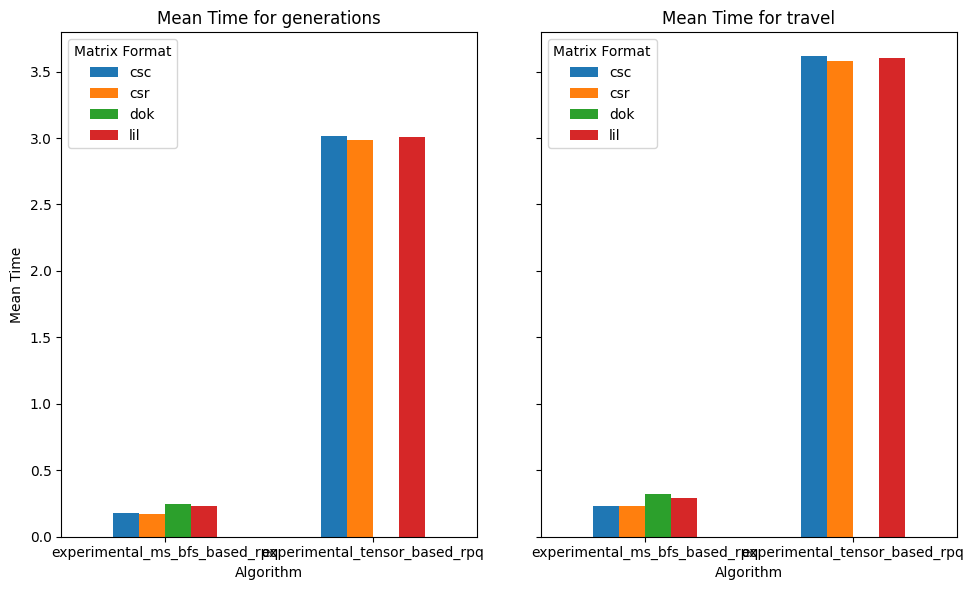

In [34]:
# number of graphs
n_graphs = len(graph_names)

# Create subplots
fig, axes = plt.subplots(1, n_graphs, figsize=(5 * n_graphs, 6), sharey=True)

# Loop through each graph_name and create a bar plot
for ax, graph in zip(axes, graph_names):
    # Group by algorithm and matrix_format, calculating the mean time
    grouped = (
        df[df["graph_name"] == graph]
        .groupby(["algorithm", "matrix_format"])["time"]
        .mean()
        .unstack()
    )

    # Plotting
    grouped.plot(kind="bar", ax=ax)
    ax.set_title(f"Mean Time for {graph}")
    ax.set_xlabel("Algorithm")
    ax.set_ylabel("Mean Time")
    ax.set_xticks(range(len(grouped.index)))
    ax.set_xticklabels(grouped.index, rotation=0)
    ax.legend(title="Matrix Format")

# Adjust layout and show
plt.tight_layout()
plt.show()

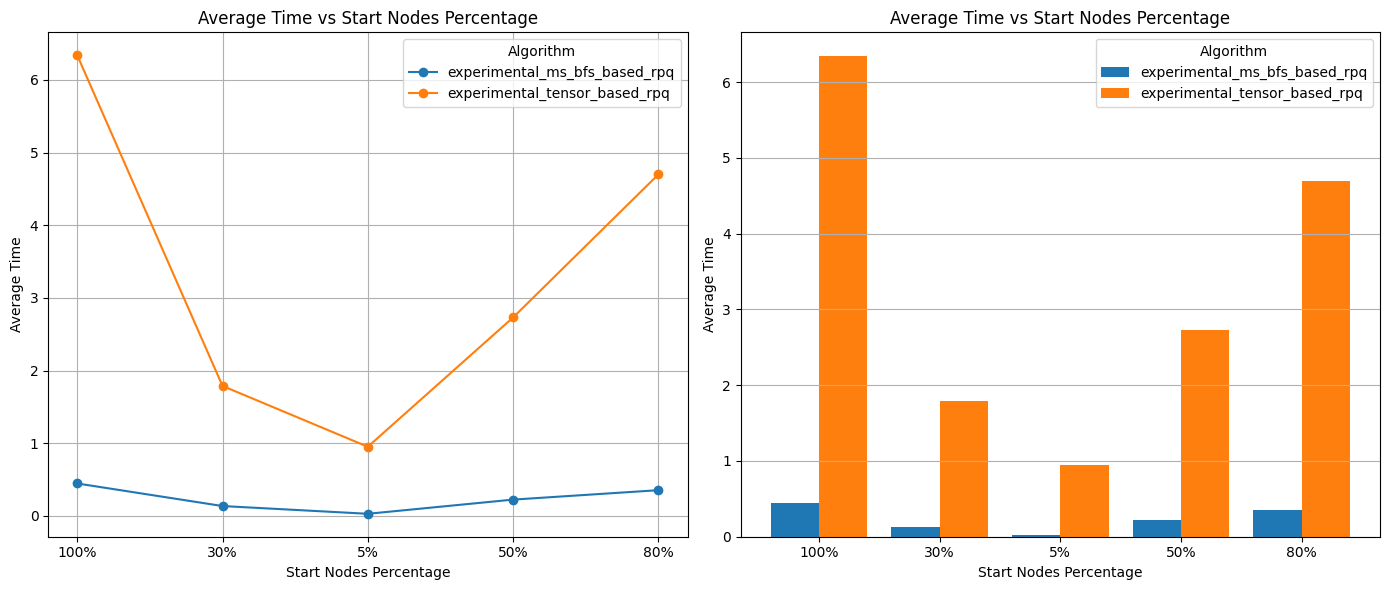

In [35]:
# Group by 'algorithm' and 'start_nodes_percentage', then calculate the average 'time'
avg_time = (
    df.groupby(["algorithm", "start_nodes_percentage"])["time"].mean().reset_index()
)

# Pivot the DataFrame to get algorithms as columns
pivot_df = avg_time.pivot(
    index="start_nodes_percentage", columns="algorithm", values="time"
)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the line chart
for algorithm in pivot_df.columns:
    axes[0].plot(pivot_df.index, pivot_df[algorithm], marker="o", label=algorithm)

axes[0].set_title("Average Time vs Start Nodes Percentage")
axes[0].set_xlabel("Start Nodes Percentage")
axes[0].set_ylabel("Average Time")
axes[0].set_xticks(pivot_df.index)  # Ensure all x-ticks are shown
axes[0].legend(title="Algorithm")
axes[0].grid()

# Plotting the bar chart
pivot_df.plot(kind="bar", ax=axes[1], width=0.8)

axes[1].set_title("Average Time vs Start Nodes Percentage")
axes[1].set_xlabel("Start Nodes Percentage")
axes[1].set_ylabel("Average Time")
axes[1].set_xticks(range(len(pivot_df.index)))  # Ensure all x-ticks are shown
axes[1].set_xticklabels(pivot_df.index, rotation=0)
axes[1].legend(title="Algorithm")
axes[1].grid(axis="y")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

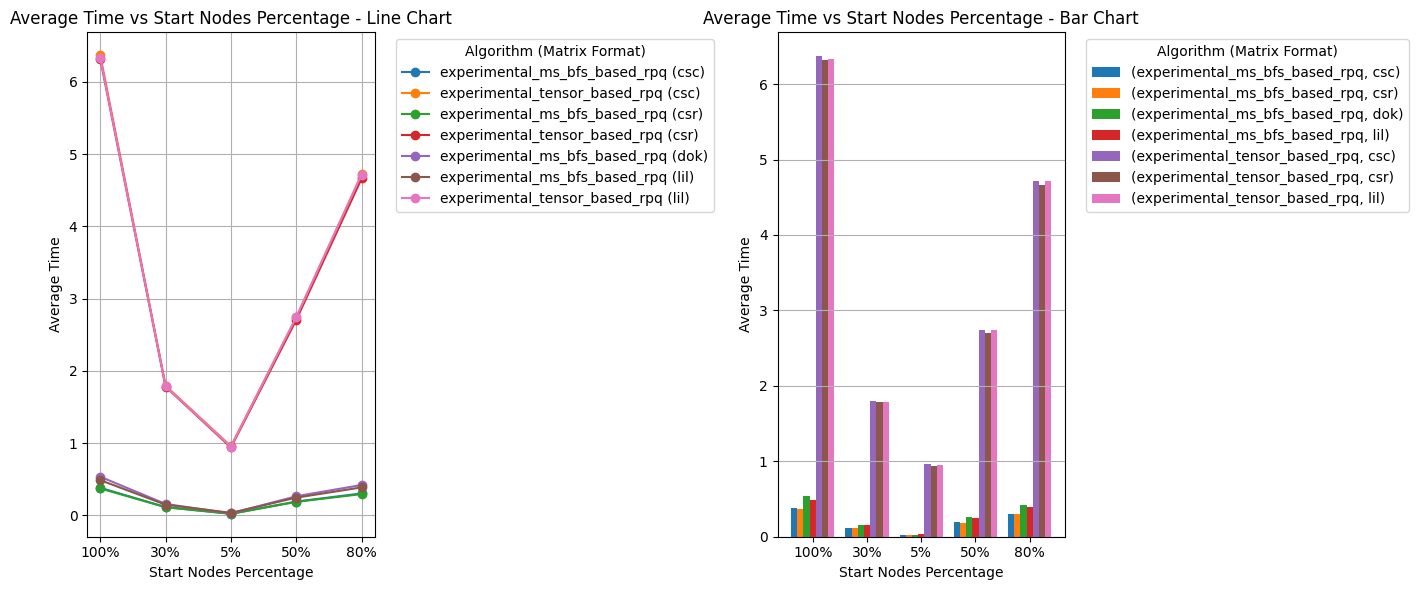

In [55]:
import matplotlib.pyplot as plt

# Group by 'algorithm', 'start_nodes_percentage', and 'matrix_format', then calculate the average 'time'
avg_time = (
    df.groupby(["algorithm", "start_nodes_percentage", "matrix_format"])["time"]
    .mean()
    .reset_index()
)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Line chart
for matrix_format in avg_time["matrix_format"].unique():
    filtered_df = avg_time[avg_time["matrix_format"] == matrix_format]
    pivot_df = filtered_df.pivot(
        index="start_nodes_percentage", columns="algorithm", values="time"
    )

    # Plotting each matrix format on the same axes
    for algorithm in pivot_df.columns:
        axes[0].plot(
            pivot_df.index,
            pivot_df[algorithm],
            marker="o",
            label=f"{algorithm} ({matrix_format})",
        )

axes[0].set_title("Average Time vs Start Nodes Percentage - Line Chart")
axes[0].set_xlabel("Start Nodes Percentage")
axes[0].set_ylabel("Average Time")
axes[0].set_xticks(pivot_df.index)  # Ensure all x-ticks are shown
axes[0].legend(
    title="Algorithm (Matrix Format)", bbox_to_anchor=(1.05, 1), loc="upper left"
)
axes[0].grid()

# Bar chart
bar_data = avg_time.pivot_table(
    index="start_nodes_percentage",
    columns=["algorithm", "matrix_format"],
    values="time",
    aggfunc="mean",
)
bar_data.plot(kind="bar", ax=axes[1], width=0.8)

axes[1].set_title("Average Time vs Start Nodes Percentage - Bar Chart")
axes[1].set_xlabel("Start Nodes Percentage")
axes[1].set_ylabel("Average Time")
axes[1].set_xticks(range(len(bar_data.index)))  # Ensure all x-ticks are shown
axes[1].set_xticklabels(bar_data.index, rotation=0)
axes[1].legend(
    title="Algorithm (Matrix Format)", bbox_to_anchor=(1.05, 1), loc="upper left"
)
axes[1].grid(axis="y")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Результаты эксперимента показали, что во всех случаях `csr_matrix` является наиболее эффективным, а следовательно и наиболее подходящим представлением разреженных матриц для решаемых задач достижимоси. Результаты работы алгоритмов с использованием `lil_matrix` являются сравнимыми с `csr_matrix`.

Напротив, представление `dok_matrix` является наименее эффективным при использовании алгоритма `ms_bfs_based_rqp` и крайне непроизводительным в случае использования алгоритма `tensor_based_rpq`.

На графиках можно увидеть, что размер множества стартовых вершин, составляющий 5% от общего количества вершин графа является наиболее эффективным для всех рассмотренных комбинаций алгоритмов, графов и представлений разреженных матриц. В общем случае можно заметить, что с увеличением количества стартовых вершин растет время работы алгоритмов.

### Вывод

Полученные результаты отличаются от теоретических ожиданий. В общем случае ожидается, что для графов с небольшим количеством вершин и несложных регулярных выражений выбирать поиск для всех пар (`tensor_based_rpq`) будет выгоднее, а для больших графов и сложных регулярных выражений предпочтительнее будет использовать поиск для заданного множества стартовых вершин (`ms_bfs_based_rpq`). 

Такие результаты эксперимента вероятнее всего вызваны неоптимальной реализацией алгоритма `tensor_based_rpq`. Ключевые недостатки реализации:
- Преобразование разреженных матриц в плотные в методе `transitive_closure`
- Неэффективное вычисление транзитивного замыкания (большая асимптотическая сложность (O($n^3$)) метода `np.linalg.matrix_power`)
- Избыточные вычисления и дублирование операций
- Неоптимальная работа с разреженными структурами (преобразование в плотный массив для проверки пустоты)

Вышеперечисленные недостатки реализации повлекли за собой рост времени выполнения, увеличенное потребление памяти, неэффективное использование разреженных представлений, а как следствие - искаженный результат эксперимента.